# Malware DNS tunnels detection using NetTiSA flows

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split



In [2]:
df = pd.read_csv("../final_datasets/dns_malware.csv")
df

,Unnamed: 0,SRC_IP,DST_IP,SRC_PORT,DST_PORT,TIME_FIRST,TIME_LAST,LABEL,PACKETS,PACKETS_REV,...,ROOT_MEAN_SQUARE,KURTOSIS,TIME_DISTRIBUTION,MEAN_RELATIVE_TIME,DURATION,MEAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,SWITCHING_METRIC,DIRECTIONS
0,0,150.150.150.10,8.8.8.8,46177,53,1.571319e+09,1.571320e+09,True,397,396,...,123.285176,2.699452,0.543803,163.085761,299.898332,0.378660,0.000025,5.005048,1.795455,0.500631
1,1,150.150.150.10,8.8.8.8,46177,53,1.571320e+09,1.571320e+09,True,633,634,...,124.510483,3.213281,0.562057,168.496946,299.786230,0.236798,0.000141,5.005074,1.935229,0.499605
2,2,150.150.150.10,8.8.8.8,46177,53,1.571320e+09,1.571320e+09,True,552,551,...,124.511936,2.246711,0.386026,115.716338,299.763384,0.272018,0.000135,5.005108,1.898367,0.500453
3,3,150.150.150.10,8.8.8.8,46177,53,1.571320e+09,1.571321e+09,True,453,454,...,122.715279,2.561905,0.503319,150.313386,298.644213,0.329629,0.000057,5.005081,1.843267,0.499449
4,4,150.150.150.10,8.8.8.8,46177,53,1.571321e+09,1.571321e+09,True,543,542,...,122.563972,3.047176,0.560376,166.938134,297.903898,0.274819,0.000131,5.005033,1.894834,0.500461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,6385,150.150.150.10,8.8.8.8,58075,53,1.568126e+09,1.568126e+09,False,320,320,...,120.785638,2.527719,0.556407,74.001959,132.999575,0.208137,0.000185,4.968214,1.978091,0.500000
6386,6386,150.150.150.10,8.8.8.8.,53737,53,1.566519e+09,1.566519e+09,False,7,0,...,71.011066,1.482977,0.342008,0.109573,0.320381,0.053397,0.000030,0.244692,1.333333,1.000000
6387,6387,150.150.150.10,8.8.8.8.,49281,53,1.566519e+09,1.566519e+09,False,7,0,...,71.011066,1.482977,0.537897,0.174689,0.324763,0.054127,0.000034,0.249081,1.333333,1.000000
6388,6388,8.8.8.8,150.150.150.10.,53,53737,1.566519e+09,1.566519e+09,False,6,0,...,294.015873,1.409161,0.378440,0.111779,0.295367,0.059073,0.000560,0.215555,1.600000,1.000000


In [172]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "KURTOSIS",
    "TIME_DISTRIBUTION",
    "MEAN_RELATIVE_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
]

In [173]:
import sklearn
pd.set_option('display.max_columns', None)

df = df[["LABEL"] + features].copy()

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes


for F in features:
    df.replace([np.inf], 0, inplace=True)
    df.replace([-np.inf], 0, inplace=True)
    df.loc[df[F].isnull(), F] = 0

In [174]:
df

,LABEL,PACKETS,PACKETS_REV,BYTES,BYTES_REV,MEAN,STDEV,VAR,BURSTINESS,MIN,MAX,MIN_MINUS_MAX,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,KURTOSIS,TIME_DISTRIBUTION,MEAN_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,SWITCHING_METRIC,DIRECTIONS,LABEL_code
0,True,397,396,13891,32844,118,32.480764,1056,-0.568307,85,243,158,27.526071,28,23.728814,123.285176,2.699452,0.543803,163.085761,299.898332,0.378660,0.000025,5.005048,1.795455,0.500631,1
1,True,633,634,21194,54658,119,33.689761,1136,-0.558716,85,254,169,28.310724,29,24.369748,124.510483,3.213281,0.562057,168.496946,299.786230,0.236798,0.000141,5.005074,1.935229,0.499605,1
2,True,552,551,18276,47900,119,33.241540,1106,-0.563305,85,248,163,27.934067,30,25.210084,124.511936,2.246711,0.386026,115.716338,299.763384,0.272018,0.000135,5.005108,1.898367,0.500453,1
3,True,453,454,14459,38276,118,33.196385,1102,-0.560884,84,248,164,28.132530,30,25.423729,122.715279,2.561905,0.503319,150.313386,298.644213,0.329629,0.000057,5.005081,1.843267,0.499449,1
4,True,543,542,17855,45360,118,32.186954,1036,-0.571375,84,271,187,27.277080,28,23.728814,122.563972,3.047176,0.560376,166.938134,297.903898,0.274819,0.000131,5.005033,1.894834,0.500461,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,False,320,320,11040,25577,117,29.171904,851,-0.600855,86,218,132,24.933252,25,21.367521,120.785638,2.527719,0.556407,74.001959,132.999575,0.208137,0.000185,4.968214,1.978091,0.500000,0
6386,False,7,0,66,0,69,16.093477,259,-0.621746,60,93,33,23.323880,13,18.840580,71.011066,1.482977,0.342008,0.109573,0.320381,0.053397,0.000030,0.244692,1.333333,1.000000,0
6387,False,7,0,66,0,69,16.093477,259,-0.621746,60,93,33,23.323880,13,18.840580,71.011066,1.482977,0.537897,0.174689,0.324763,0.054127,0.000034,0.249081,1.333333,1.000000,0
6388,False,6,0,868,0,204,231.231486,53468,0.062568,60,584,524,113.348768,192,94.117647,294.015873,1.409161,0.378440,0.111779,0.295367,0.059073,0.000560,0.215555,1.600000,1.000000,0


In [175]:
print(f"ddos: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

ddos: 257	clear: 6133


In [176]:
df = df[["LABEL_code"] + features].copy()

In [177]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [178]:
df.shape

(6390, 25)

In [179]:
print(f"malware dns: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

malware dns: 257	clear: 6133


In [180]:
df_validation = df.sample(n = 1000)
df_features =  df[~df.isin(df_validation)].dropna()

In [181]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [182]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 60, 5),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 40, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 600, 50),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [183]:
best_hyperparams = tunne_together_XGBoost_classification(df_features, features, verbose=False)

100%|██████████| 100/100 [00:06<00:00, 16.19trial/s, best loss: -0.8070175438596492]
The best hyperparameters are :  

{'colsample_bytree': 0.10851242207783068, 'gamma': 1.8614148491796003, 'max_depth': 55.0, 'min_child_weight': 1.0, 'n_estimators': 600.0, 'reg_alpha': 1.0, 'reg_lambda': 0.18200314335280884}


In [184]:
def XGBoost_classification_tunned(best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['LABEL_code']  # Labels
      #Split on train and test
      X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
      X_train = X_train_a[features]
      X_test = X_test_a[features] 
      model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      
      accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
      precision = precision_score(y_test, y_pred)  * 100
      recall = recall_score(y_test, y_pred)  * 100
      F1 = f1_score(y_test, y_pred)  * 100
      print("{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
      matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      return model

99.26 & 96.49 & 84.62 & 90.16 \\


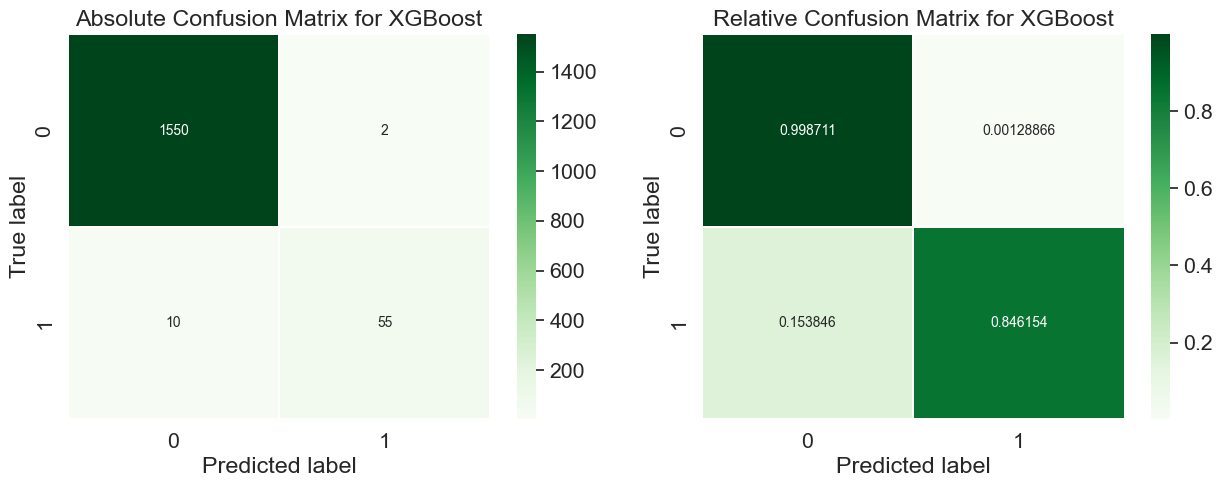

In [185]:
model = XGBoost_classification_tunned(best_hyperparams)

In [186]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        for F, N in zip(
                [ features], # statistics_features, time_features, distribution_features, frequency_features, behavior_features, 
                [ "All"], # "Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", 
        ):
                X_train = X_train_a[F]
                X_test = X_test_a[F] 
                model = XGBClassifier(
                        n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                        reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                        colsample_bytree=int(best_hyperparams['colsample_bytree']),
                        # subsample=int(best_hyperparams['subsample']),
                        # eta=best_hyperparams['eta'],
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
                precision = precision_score(y_test, y_pred)  * 100
                recall = recall_score(y_test, y_pred)  * 100
                F1 = f1_score(y_test, y_pred)  * 100
                if N == "All":
                    tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\hline"
                    tmp_str += "\n"
                    tmp_f1 = F1
                elif N in ["Statistical-based", "Distribution-based", "Behavior-based"]:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
                else:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & \\rowcolor{LigthGray} " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
        if best_results[0] < tmp_f1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (tmp_f1, tmp_str, matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

24


94.30894308943091
\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}99.57 & 100.00 & 89.23 & 94.31 \\
\hline



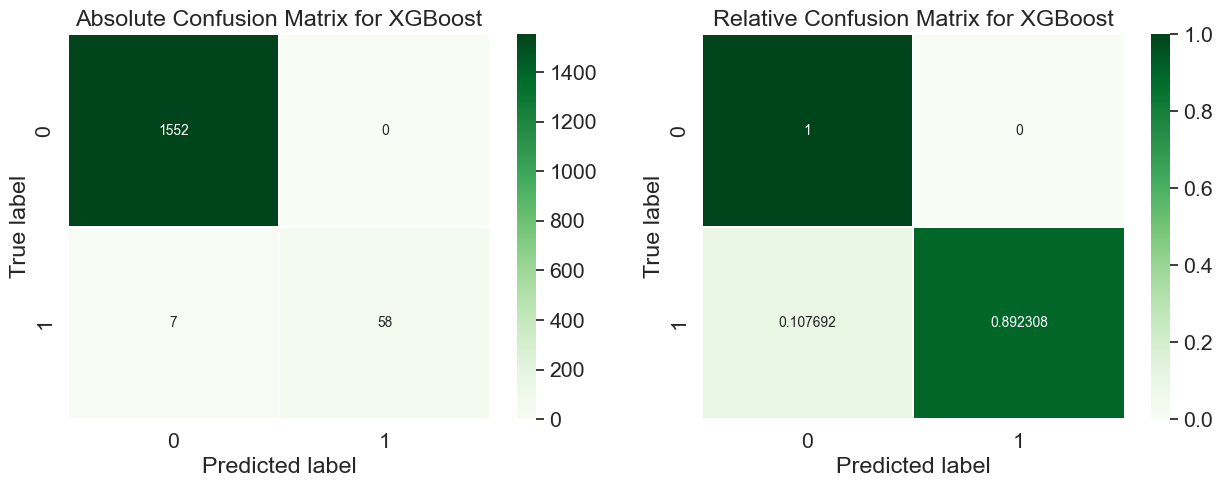

In [187]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=25)

99.40 & 97.22 & 87.50 & 92.11 \\


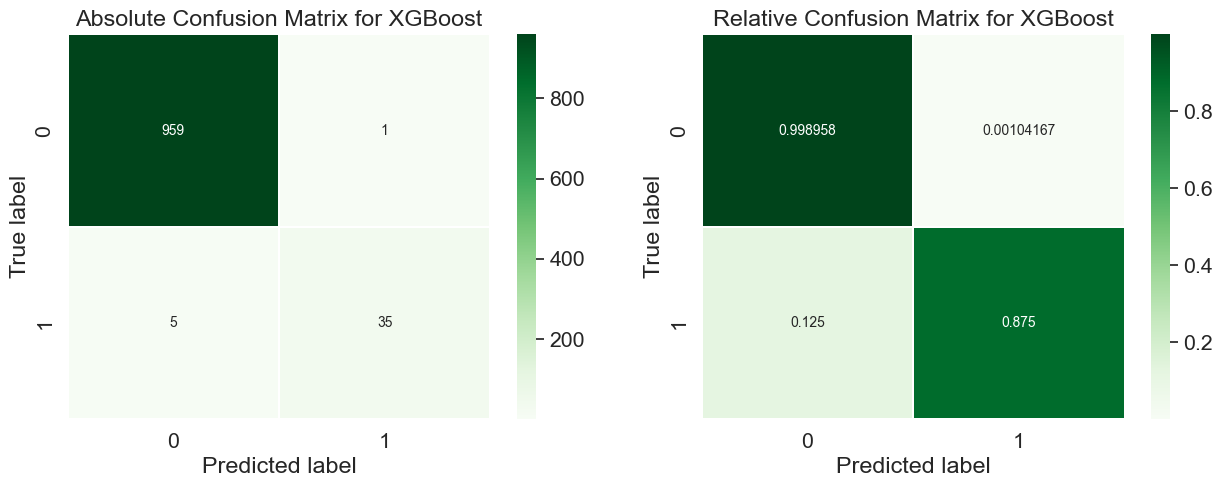

In [188]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

## Feature importance

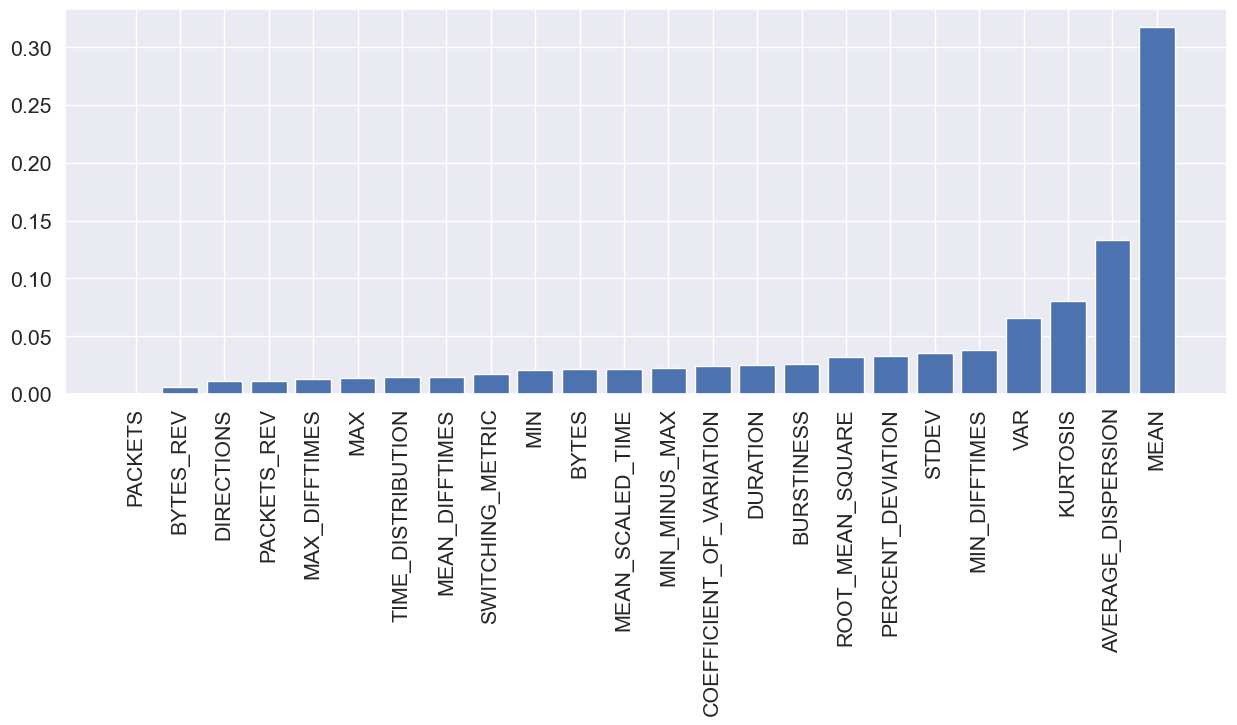

In [189]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [190]:
feat_importances.to_dict()

{'PACKETS': 0.0,
 'BYTES_REV': 0.006217887159436941,
 'DIRECTIONS': 0.01109268981963396,
 'PACKETS_REV': 0.011173713952302933,
 'MAX_DIFFTIMES': 0.0130781764164567,
 'MAX': 0.013663280755281448,
 'TIME_DISTRIBUTION': 0.014541949145495892,
 'MEAN_DIFFTIMES': 0.015091340988874435,
 'SWITCHING_METRIC': 0.017655594274401665,
 'MIN': 0.020987937226891518,
 'BYTES': 0.021295594051480293,
 'MEAN_SCALED_TIME': 0.021840166300535202,
 'MIN_MINUS_MAX': 0.022935645654797554,
 'COEFFICIENT_OF_VARIATION': 0.024334518238902092,
 'DURATION': 0.025250619277358055,
 'BURSTINESS': 0.026258181780576706,
 'ROOT_MEAN_SQUARE': 0.032221052795648575,
 'PERCENT_DEVIATION': 0.03272763639688492,
 'STDEV': 0.03553280234336853,
 'MIN_DIFFTIMES': 0.03803341090679169,
 'VAR': 0.06585489958524704,
 'KURTOSIS': 0.08009364455938339,
 'AVERAGE_DISPERSION': 0.1330120861530304,
 'MEAN': 0.317107230424881}